In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams.update({'figure.dpi': 300})

In [47]:
import numpy as np
from scipy.optimize import minimize
from scipy.spatial import distance
from numpy.random import multivariate_normal
import pandas as pd
from tqdm import tqdm

### Define General Setting

In [35]:
d = 100
N = 10

In [36]:
np.random.seed(1993)  # set seed for repetative results.

### Define Dataset (Woodworth et al.)

In [37]:
s = 5
noise_var = 0.01

X_train = multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=N)
X_test = multivariate_normal(mean=np.zeros(d), cov=np.eye(d), size=2000)
w_star = np.zeros(d)
support = np.random.choice(np.arange(d), s, replace=False)
w_star[support] = 1/np.sqrt(s)
y_train = np.dot(X_train, w_star) + np.sqrt(noise_var) * np.random.randn(N)
y_test = np.dot(X_test, w_star)

# reshape 
X_train = X_train.transpose()
X_test = X_test.transpose()
y_train = y_train.reshape(1, -1)
y_test = y_test.reshape(1, -1)

In [38]:
y_train.shape, X_train.shape

((1, 10), (100, 10))

### Define Unbiased U-V model

In [13]:
def symmetric_init(alpha, s, d):
    """ initialize model weights """
    norm_u = np.sqrt(alpha * (1 - s) / (1 + s))
    norm_v = np.sqrt(alpha * (1 + s) / (1 - s))

    u_0 = np.ones((d, 1)) * norm_u
    v_0 = np.ones((d, 1)) * norm_v

    u_p_0 = u_n_0 = u_0
    v_p_0 = v_n_0 = v_0
    return u_p_0, v_p_0, u_n_0, v_n_0


def update(u_p, v_p, u_n, v_n, x, y, step_size):
    """ perform gradient decsent """
    d, n = x.shape

    w = np.multiply(u_p, v_p) - np.multiply(u_n, v_n)
    y_pred = np.matmul(w.transpose(), x)
    grad_r = -(y_pred - y)/n

    grad_xr = np.matmul(x, grad_r.transpose())

    u_p_grad = np.multiply(grad_xr, v_p)
    v_p_grad = np.multiply(grad_xr, u_p)
    u_n_grad = -np.multiply(grad_xr, v_n)
    v_n_grad = -np.multiply(grad_xr, u_n)

    u_p = u_p + step_size * u_p_grad
    v_p = v_p + step_size * v_p_grad
    u_n = u_n + step_size * u_n_grad
    v_n = v_n + step_size * v_n_grad

    return u_p, v_p, u_n, v_n


def current_training_loss(u_p, v_p, u_n, v_n, x, y):
    d, n = x.shape
    w = np.multiply(u_p, v_p) - np.multiply(u_n, v_n)
    y_pred = np.matmul(w.transpose(), x)
    return np.linalg.norm(y - y_pred, ord=2) ** 2 / n

In [14]:
def train(u_p_0, v_p_0, u_n_0, v_n_0, x, y, step_size, n_epochs, eval_freq=1000, early_stop_tol=1e-4):
    training_loss = []
    u_p_array = []
    v_p_array = []
    u_n_array = []
    v_n_array = []

    u_p, v_p, u_n, v_n = np.array(u_p_0), np.array(v_p_0), np.array(u_n_0), np.array(v_n_0)

    for epoch in tqdm(range(n_epochs)):

        u_p_updated, v_p_updated, u_n_updated, v_n_updated = update(u_p, v_p, u_n, v_n, x, y, step_size)

        if (epoch + 1) % eval_freq == 0:
            # store learned weights
            training_loss.append(current_training_loss(u_p, v_p, u_n, v_n, x, y))
            u_p_array.append(u_p.copy())
            v_p_array.append(v_p.copy())
            u_n_array.append(u_n.copy())
            v_n_array.append(v_n.copy())

            if training_loss[-1] < early_stop_tol:
                break

        u_p, v_p, u_n, v_n = u_p_updated, v_p_updated, u_n_updated, v_n_updated

    return {
        'u_p': u_p_array,
        'v_p': v_p_array,
        'u_n': u_n_array,
        'v_n': v_n_array,
        'training_loss': training_loss
    }

### Effect of Shape and Scale

In [114]:
alpha_range = np.logspace(-3, 0.5, 20)
s_range = [0, 0.5, 0.7, 0.9, 0.99]

In [115]:
results = {}
for s in s_range:
    for alpha in alpha_range:
        print(alpha, s)
        u_p_0, v_p_0, u_n_0, v_n_0 = symmetric_init(alpha=alpha, s=s, d=d)
        results[(s, alpha)] = train(
            u_p_0=u_p_0,
            v_p_0=v_p_0,
            u_n_0=u_n_0,
            v_n_0=v_n_0,
            x=X_train,
            y=y_train,
            step_size=1e-3,
            n_epochs=int(1e7),
            early_stop_tol=1e-4)

  0%|          | 1439/10000000 [00:00<11:35, 14385.56it/s]

0.001 0


  0%|          | 3912/10000000 [00:00<08:31, 19553.27it/s]

0.0015283067326587688 0


  0%|          | 3837/10000000 [00:00<08:38, 19271.25it/s]

0.002335721469090121 0


  0%|          | 3785/10000000 [00:00<08:59, 18544.68it/s]

0.0035696988468260625 0


  0%|          | 3853/10000000 [00:00<08:45, 19008.70it/s]

0.00545559478116852 0


  0%|          | 3883/10000000 [00:00<08:41, 19168.44it/s]

0.008337822234717891 0


  0%|          | 1927/10000000 [00:00<08:38, 19267.91it/s]

0.012742749857031334 0


  0%|          | 1991/10000000 [00:00<08:22, 19909.83it/s]

0.01947483039908756 0


  0%|          | 1945/10000000 [00:00<08:34, 19447.42it/s]

0.029763514416313176 0


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.04548777947003775 0
0.06951927961775606 0


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.10624678308940409 0
0.1623776739188721 0


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.24816289228368238 0
0.37926901907322497 0
0.5796393953384967 0
0.8858667904100823 0


  0%|          | 0/10000000 [00:00<?, ?it/s]

1.3538761800225432 0
2.069138081114788 0
3.1622776601683795 0
0.001 0.5


  0%|          | 3323/10000000 [00:00<10:09, 16406.31it/s]

0.0015283067326587688 0.5


  0%|          | 1546/10000000 [00:00<10:46, 15458.72it/s]

0.002335721469090121 0.5


  0%|          | 1816/10000000 [00:00<09:10, 18154.74it/s]

0.0035696988468260625 0.5


  0%|          | 1776/10000000 [00:00<09:22, 17759.09it/s]

0.00545559478116852 0.5


  0%|          | 3383/10000000 [00:00<10:20, 16123.49it/s]

0.008337822234717891 0.5


  0%|          | 3846/10000000 [00:00<08:40, 19218.53it/s]

0.012742749857031334 0.5


  0%|          | 3297/10000000 [00:00<10:04, 16549.00it/s]

0.01947483039908756 0.5


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.029763514416313176 0.5
0.04548777947003775 0.5


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.06951927961775606 0.5
0.10624678308940409 0.5


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.1623776739188721 0.5
0.24816289228368238 0.5
0.37926901907322497 0.5
0.5796393953384967 0.5


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.8858667904100823 0.5
1.3538761800225432 0.5
2.069138081114788 0.5
3.1622776601683795 0.5


  0%|          | 1589/10000000 [00:00<10:29, 15885.24it/s]

0.001 0.7


  0%|          | 3591/10000000 [00:00<09:22, 17770.85it/s]

0.0015283067326587688 0.7


  0%|          | 1787/10000000 [00:00<09:19, 17861.41it/s]

0.002335721469090121 0.7


  0%|          | 1637/10000000 [00:00<10:10, 16367.44it/s]

0.0035696988468260625 0.7


  0%|          | 1776/10000000 [00:00<09:23, 17755.74it/s]

0.00545559478116852 0.7


  0%|          | 3477/10000000 [00:00<09:36, 17352.41it/s]

0.008337822234717891 0.7


  0%|          | 3158/10000000 [00:00<10:24, 15999.92it/s]

0.012742749857031334 0.7


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.01947483039908756 0.7
0.029763514416313176 0.7


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.04548777947003775 0.7
0.06951927961775606 0.7


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.10624678308940409 0.7
0.1623776739188721 0.7
0.24816289228368238 0.7
0.37926901907322497 0.7


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.5796393953384967 0.7
0.8858667904100823 0.7
1.3538761800225432 0.7


  0%|          | 0/10000000 [00:00<?, ?it/s]

2.069138081114788 0.7
3.1622776601683795 0.7
0.001 0.9


  0%|          | 1657/10000000 [00:00<10:03, 16565.39it/s]

0.0015283067326587688 0.9


  0%|          | 3063/10000000 [00:00<11:09, 14934.46it/s]

0.002335721469090121 0.9


  0%|          | 1648/10000000 [00:00<10:06, 16479.66it/s]

0.0035696988468260625 0.9


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.00545559478116852 0.9
0.008337822234717891 0.9


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.012742749857031334 0.9
0.01947483039908756 0.9


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.029763514416313176 0.9
0.04548777947003775 0.9
0.06951927961775606 0.9


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.10624678308940409 0.9
0.1623776739188721 0.9
0.24816289228368238 0.9
0.37926901907322497 0.9


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.5796393953384967 0.9
0.8858667904100823 0.9
1.3538761800225432 0.9


  0%|          | 0/10000000 [00:00<?, ?it/s]

2.069138081114788 0.9
3.1622776601683795 0.9
0.001 0.99


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.0015283067326587688 0.99
0.002335721469090121 0.99
0.0035696988468260625 0.99


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.00545559478116852 0.99
0.008337822234717891 0.99
0.012742749857031334 0.99
0.01947483039908756 0.99


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.029763514416313176 0.99
0.04548777947003775 0.99
0.06951927961775606 0.99
0.10624678308940409 0.99


  0%|          | 0/10000000 [00:00<?, ?it/s]

0.1623776739188721 0.99
0.24816289228368238 0.99
0.37926901907322497 0.99


  0%|          | 0/10000000 [00:00<?, ?it/s]/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in multiply
/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in multiply
/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in multiply
/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in multiply
/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in matmul
  0%|          | 1483/10000000 [00:00<11:14, 14827.04it/s]

0.5796393953384967 0.99


  0%|          | 3165/10000000 [00:00<10:36, 15717.47it/s]

0.8858667904100823 0.99


  0%|          | 0/10000000 [00:00<?, ?it/s]/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in subtract
  0%|          | 1542/10000000 [00:00<10:48, 15417.11it/s]

1.3538761800225432 0.99


  0%|          | 901/10000000 [00:00<18:29, 9009.47it/s]

2.069138081114788 0.99


  0%|          | 1687/10000000 [00:00<09:53, 16859.57it/s]

3.1622776601683795 0.99


100%|██████████| 10000000/10000000 [09:42<00:00, 17170.36it/s]


In [116]:
test_loss = {}

for k, v in results.items():
    u_p, v_p, u_n, v_n = v['u_p'][-1], v['v_p'][-1], v['u_n'][-1], v['v_n'][-1]
    w = np.multiply(u_p, v_p) - np.multiply(u_n, v_n)
    test_loss[k] = current_training_loss(u_p, v_p, u_n, v_n, X_test, y_test)

([], <a list of 0 Text major ticklabel objects>)

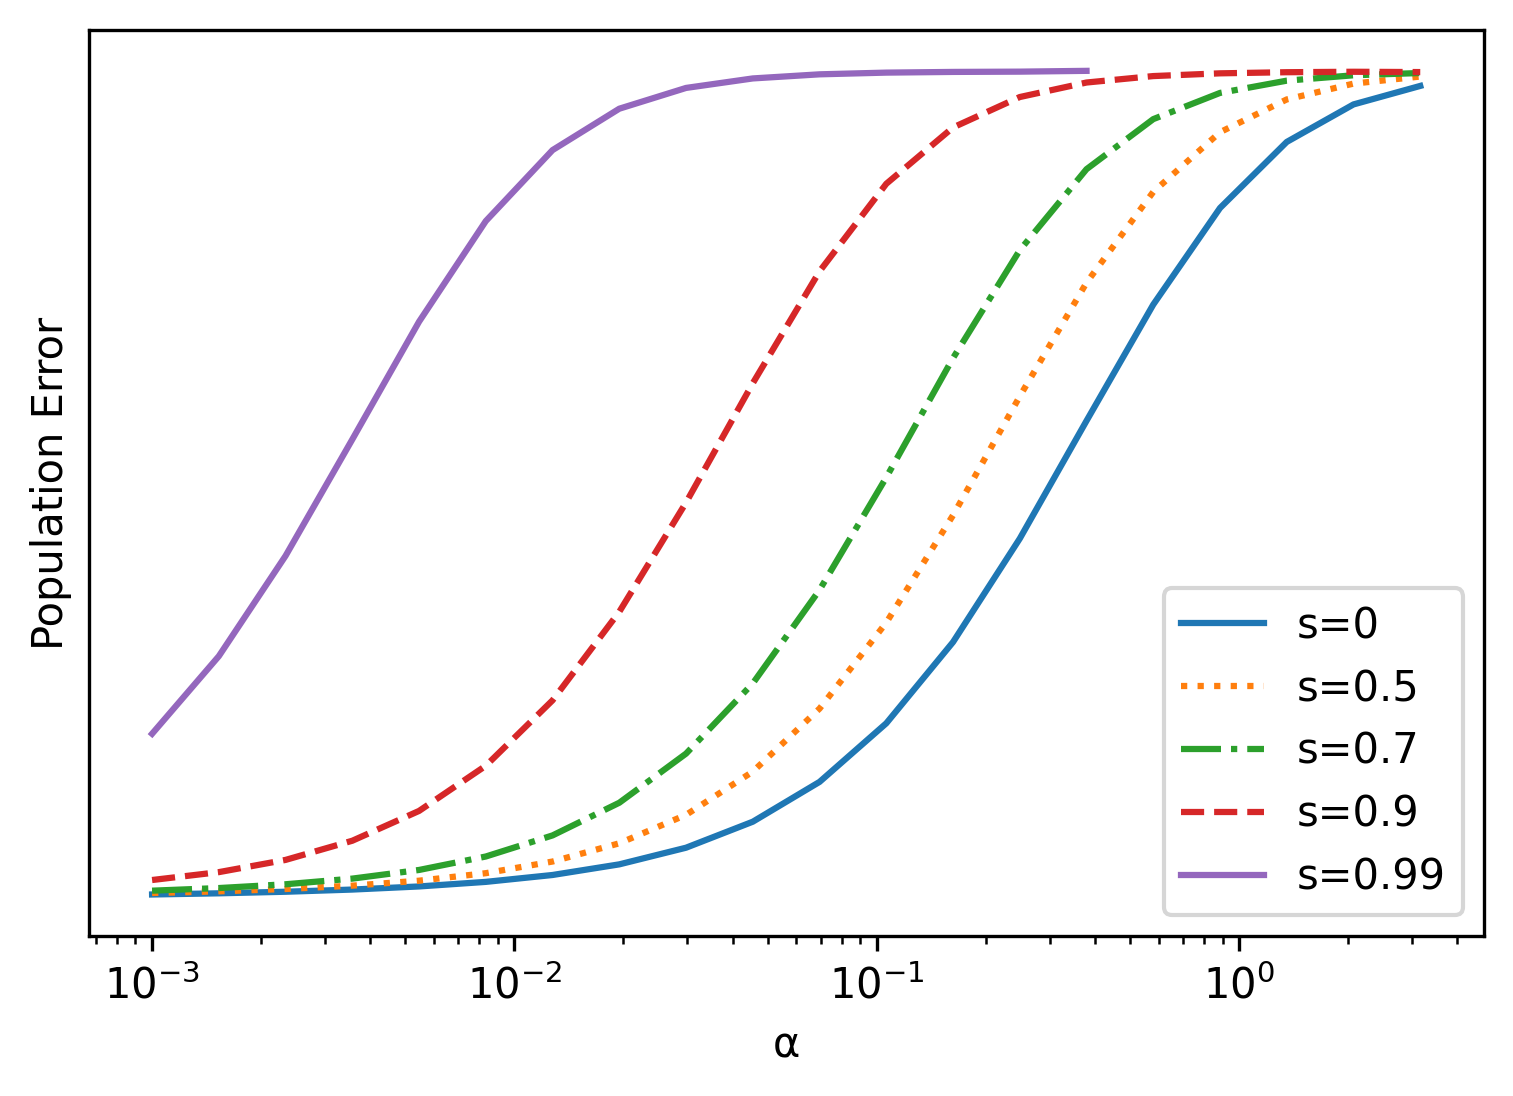

In [119]:
linstyles = ['', ':', '-.', '--', '-']

for s, style in zip(s_range, linstyles):
    plot(alpha_range, [v for k, v in test_loss.items() if k[0] == s], style)
    
legend([f's={s}' for s in s_range])
ylabel('Population Error')
xlabel('α')
xscale('log')
plt.yticks([])

## Define Q Function

$$q_k(x) =\frac{1}{2}\int_{0}^{x}\mathrm{arcsinh}\left(\frac{2z}{\sqrt{k}}\right)dz=
\frac{\sqrt{k}}{4}\left[1-\sqrt{1+\frac{4x^{2}}{k}}+\frac{2x}{\sqrt{k}}\mathrm{arcsinh}\left(\frac{2x}{\sqrt{k}}\right)\right]$$

$$\sqrt{k_i}=2\left(u_{+,i}^{2}\left(0\right)+v_{+,i}^{2}\left(0\right)\right)$$

In [39]:
def q_func(x, u_p_0, v_p_0, u_n_0, v_n_0):
    f = 0
    for i in range(len(x)):
        k = 2 * u_p_0[i] ** 2 + 2 * v_p_0[i] ** 2
        f += (k/4) * (1 - np.sqrt(1 + 4*x[i]**2/k**2) + (2*x[i]/k) * np.arcsinh(2*x[i]/k))
    return f

In [40]:
def constraint(v, x, y):
    return (np.matmul(v.reshape(-1, 1).transpose(), x) - y).squeeze()


def solver(x, y, u_p_0, v_p_0, u_n_0, v_n_0, obj='Q', optim_tol=1e-5):
    x0 = (np.multiply(u_p_0, v_p_0) - np.multiply(u_n_0, v_n_0)).reshape(-1,)

    cons = {'type': 'eq', 'fun': lambda v: constraint(v, x, y)}

    if obj == 'L1':
        objective = lambda v: np.linalg.norm(v, ord=1)
    elif obj == 'L2':
        objective = lambda v: np.linalg.norm(v, ord=2)
    elif obj == 'Q':
        objective = lambda v: q_func(v.reshape(-1, 1), u_p_0, v_p_0, u_n_0, v_n_0)
    else:
        raise ValueError('objective not supported.')

    sol = minimize(
        fun=objective,
        x0=x0,
        constraints=cons,
        tol=optim_tol,
        method='SLSQP',
        options={
            'maxiter': 100000,
            'disp': False
        }
    )
    is_failed = (not sol.success)
    if is_failed:
        raise RuntimeError('Minimization Failed.')

    return sol.x

### Compare Q to GD

In [76]:
alpha = 0.0001
s = 0.5
u_p_0, v_p_0, u_n_0, v_n_0 = symmetric_init(alpha=alpha, s=s, d=d)

results = train(
    u_p_0=u_p_0,
    v_p_0=v_p_0,
    u_n_0=u_n_0,
    v_n_0=v_n_0,
    x=X_train,
    y=y_train,
    step_size=1e-3,
    n_epochs=int(1e7),
    early_stop_tol=1e-10)

  1%|          | 120999/10000000 [00:01<02:40, 61379.53it/s]


In [77]:
w_0 = np.multiply(u_p_0, v_p_0) - np.multiply(u_n_0, v_n_0)
w_GD = np.multiply(results['u_p'][-1], results['v_p'][-1]) - np.multiply(results['u_n'][-1], results['v_n'][-1])

In [78]:
# sanity check that w_0 is unbiased
w_0[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [79]:
w_Q = solver(
    x=X_train,
    y=y_train,
    u_p_0=u_p_0,
    v_p_0=v_p_0,
    u_n_0=u_n_0,
    v_n_0=v_n_0,
    obj='Q',
    optim_tol=1e-5
)

In [80]:
w_Q.flatten()[:10]

array([-0.05757536,  0.00111363, -0.00022824,  0.0044607 , -0.00032774,
        0.00021206, -0.00540624, -0.00183456, -0.05590369, -0.001351  ])

In [81]:
w_GD.flatten()[:10]

array([-0.05772427,  0.0011148 , -0.00023367,  0.00445458, -0.0003256 ,
        0.00021057, -0.00548506, -0.00181605, -0.05581603, -0.00136804])

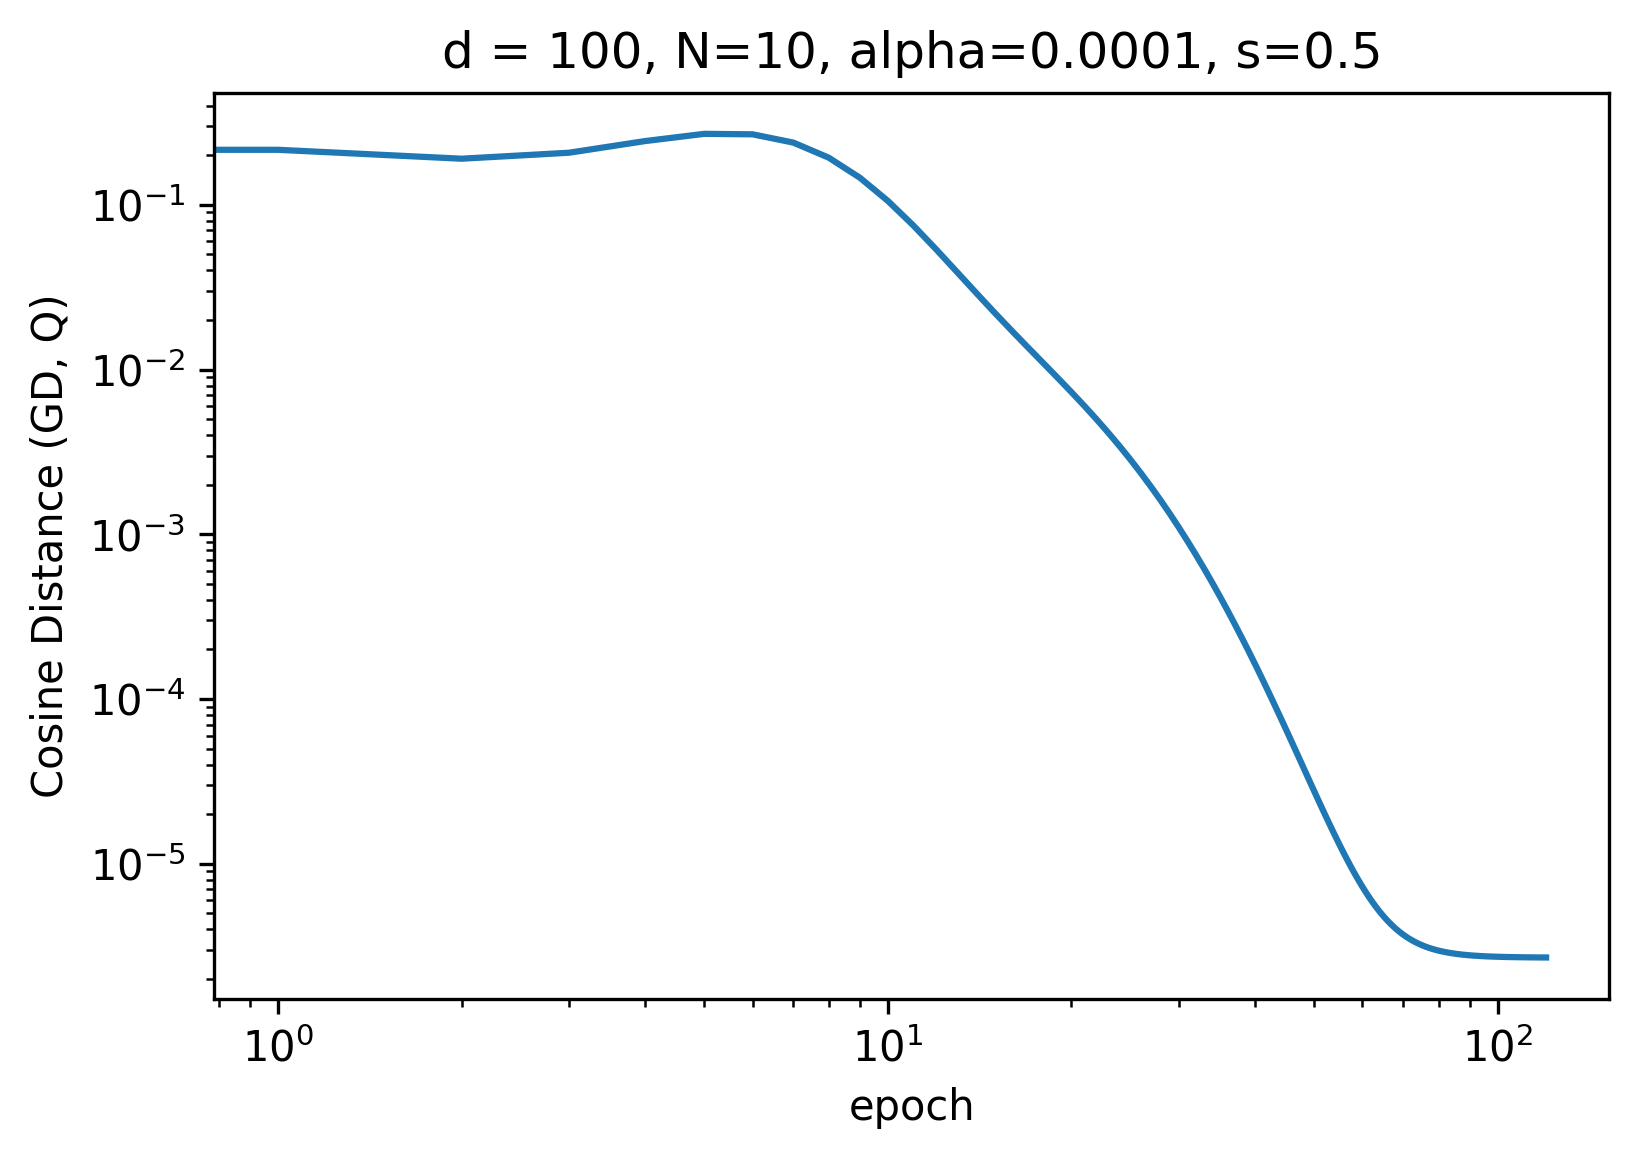

In [82]:
plot([
    distance.cosine((np.multiply(u_p, v_p) - np.multiply(u_n, v_n)).flatten(), w_Q.flatten())
         for u_p, v_p, u_n, v_n in zip(results['u_p'], results['v_p'], results['u_n'], results['v_n'])])

title(f'd = {d}, N={N}, alpha={alpha}, s={s}')
ylabel('Cosine Distance (GD, Q)')
xlabel('epoch')
xscale('log')
yscale('log')